In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cabm.agent_functions import (
    sample_normal_min,
    sample_beta_min,
    logistic_function,
    magnitude_adjusted_softmax,
    get_ad_impact_on_purchase_probabilities,
    get_probability_of_change_in_units_purchased_due_to_price,
    get_probability_of_change_in_units_purchased_due_to_adstock,
)

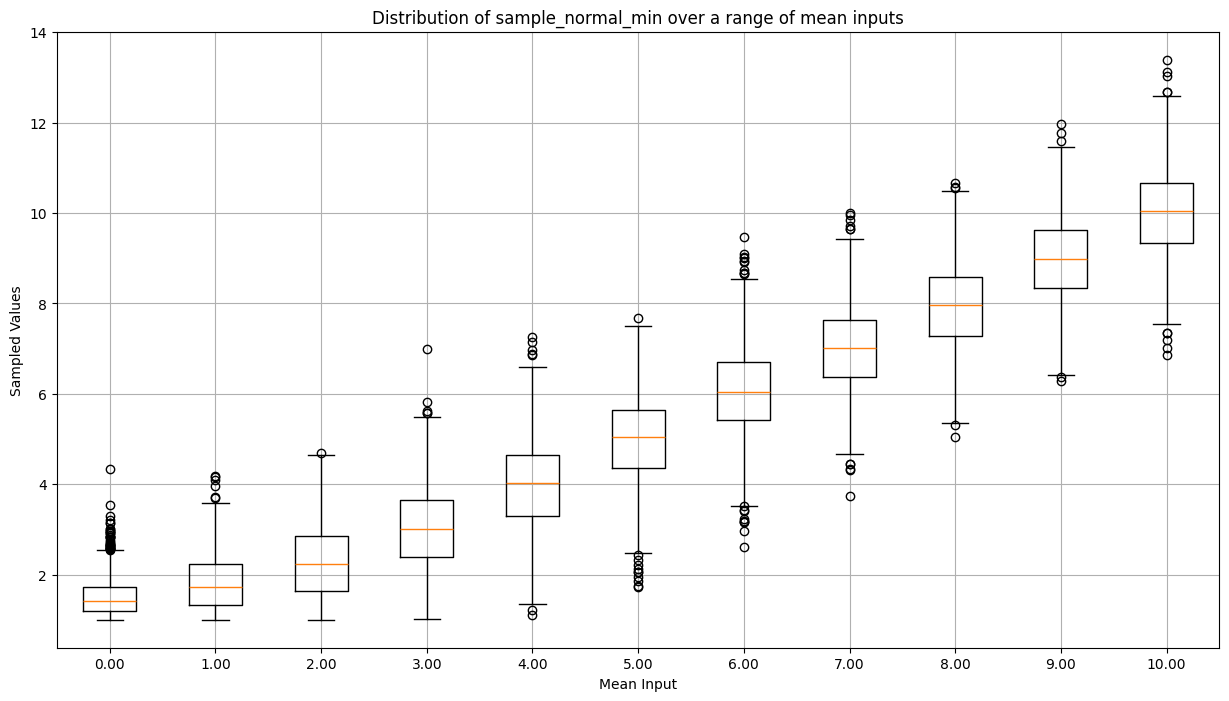

In [2]:
def visualize_sample_normal_min(mean_range, std_dev=1.0, min_value=1.0, override=0, num_samples=1000):
    all_samples = []

    for mean in mean_range:
        mean_samples = [sample_normal_min(mean, std_dev, min_value, override) for _ in range(num_samples)]
        all_samples.append(mean_samples)

    plt.figure(figsize=(15, 8))
    plt.boxplot(all_samples, positions=mean_range, widths=0.5)
    plt.xlabel('Mean Input')
    plt.ylabel('Sampled Values')
    plt.title('Distribution of sample_normal_min over a range of mean inputs')
    plt.grid(True)
    
    # Format x-axis tick labels to show fewer decimal places
    plt.xticks(ticks=mean_range, labels=[f'{mean:.2f}' for mean in mean_range])
    
    plt.show()

# Define the range of mean values
mean_range = [i for i in range(0,11)]

# Visualize the function
visualize_sample_normal_min(mean_range)

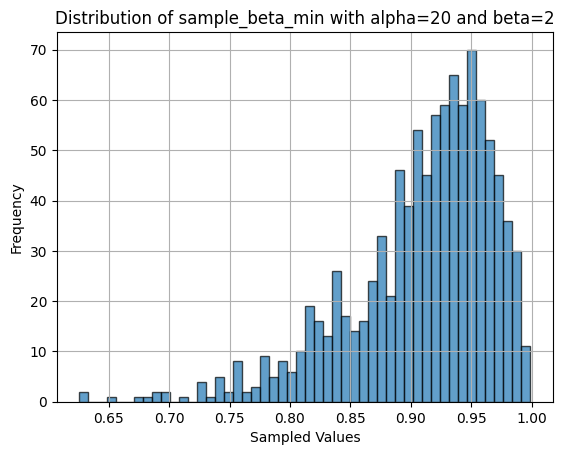

In [3]:
alpha = 20
beta = 2
samps = [sample_beta_min(alpha=alpha,beta=beta) for i in range(1000)]
plt.hist(samps, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Sampled Values')
plt.ylabel('Frequency')
plt.title(f'Distribution of sample_beta_min with alpha={alpha} and beta={beta}')
plt.grid(True)
    
plt.show()

In [4]:
logarithmic_range = np.array([1,10,100,1000,10000,100000,1000000])

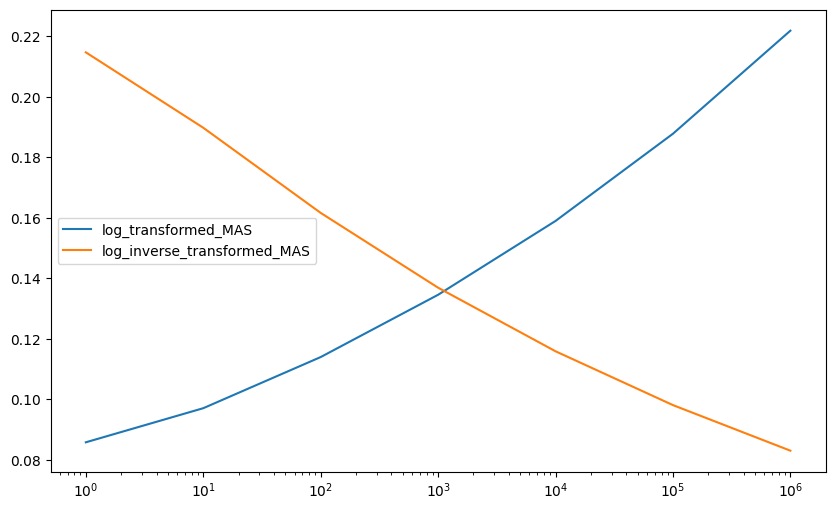

In [5]:
log_transformed_MAS = magnitude_adjusted_softmax(logarithmic_range)
log_inverse_transformed_MAS = magnitude_adjusted_softmax(logarithmic_range, inverse=True)
no_temp_log_transformed_MAS = magnitude_adjusted_softmax(logarithmic_range, magnitude_adjusted_temperature=False)

plt.figure(figsize=(10, 6))
plt.plot(logarithmic_range, log_transformed_MAS, label='log_transformed_MAS')
plt.plot(logarithmic_range, log_inverse_transformed_MAS, label='log_inverse_transformed_MAS')
#plt.plot(logarithmic_range, no_temp_log_transformed_MAS, label='no_temp_log_transformed_MAS')
plt.xscale('log')
#plt.yscale('log')
plt.legend()

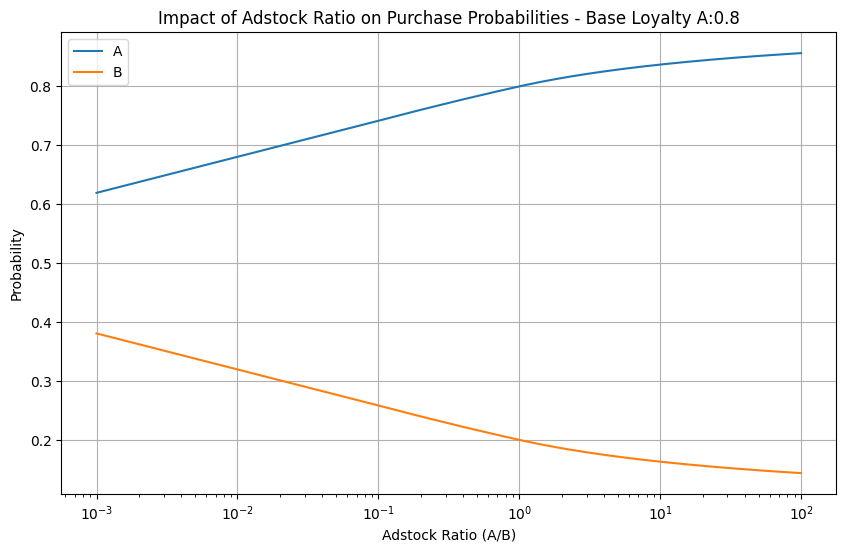

In [6]:
# Define the range for "A" adstock
adstock_A_range = range(1, 100001, 100)

# Initialize lists to store the results
prob_A = []
prob_B = []
adstock_ratios = []  # List to store the adstock ratios

# Iterate over the adstock_A_range
for adstock_A in adstock_A_range:
    adstock_B = 1000
    adstock = {"A": adstock_A, "B": adstock_B}
    brand_preference = "A"
    loyalty_rate = 0.8

    # Get the probabilities
    probabilities = get_ad_impact_on_purchase_probabilities(adstock=adstock, brand_preference=brand_preference, loyalty_rate=loyalty_rate)
    
    # Store the probabilities
    prob_A.append(probabilities['A'])
    prob_B.append(probabilities['B'])

    # Calculate and store the adstock ratio
    adstock_ratios.append(adstock_A / adstock_B)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(adstock_ratios, prob_A, label='A')  # Use adstock_ratios as x-axis values
plt.plot(adstock_ratios, prob_B, label='B')  # Use adstock_ratios as x-axis values
plt.xlabel('Adstock Ratio (A/B)')
plt.xscale('log')
plt.ylabel('Probability')
plt.title('Impact of Adstock Ratio on Purchase Probabilities - Base Loyalty A:0.8')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def SHIMMED_get_price_impact_on_brand_choice_probabilities(
    price_list,
    brand_preference,
    loyalty_rate,
):
    """
    Note - see original function signature below - instead of constructing the price list
    from week number and joint calendar, a mock price list is passed to this modified func

    This function calculates the probability of purchasing each brand.
    Note that there is separate logic for how much of a chosen brand to purchase,
    this differs by setting probability of switching brands based on price.

    Parameters:
    week_number (int): The week number.
    brand_list (List[str]): A list of all available brands.
    joint_calendar (pd.DataFrame): A DataFrame containing the joint calendar.
    brand_preference (str): The preferred brand.
    loyalty_rate (float): The loyalty rate.

    Returns:
    dict: A dictionary mapping brands to their purchase probabilities.
    """
    #price_list = {}

    # Generate price list for all brands
    # try:
    #     for brand in brand_list:
    #         price_list[brand] = joint_calendar.loc[week_number, (brand, "price")]
    # except Exception as e:
    #     print(f"Could not generate price list: {e}")

    try:
        brands = list(price_list.keys())
        price_list_values = np.array(list(price_list.values()))

        # Apply inverse softmax transformation to price list to get normalized probability distribution
        transformed_price_list = magnitude_adjusted_softmax(
            price_list_values, log_transform=False, inverse=True
        )

        # Initialize base probabilities with equal chance for non-preferred brands
        base_probabilities = np.full_like(
            transformed_price_list, (1 - loyalty_rate) / (len(brands) - 1)
        )

        # Update the base probability of the preferred brand with the loyalty rate
        brand_preference_index = brands.index(brand_preference)
        base_probabilities[brand_preference_index] = loyalty_rate

        # Adjust the base probabilities with the transformed price list values
        adjusted_probabilities = transformed_price_list * base_probabilities

        # Normalize the adjusted probabilities so they sum to 1
        probabilities = adjusted_probabilities / np.sum(adjusted_probabilities)

        # Return a dictionary mapping brands to their purchase probabilities

    except ZeroDivisionError:
        print("Error: Division by zero.")
    except KeyError as e:
        print(f"KeyError: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return dict(zip(brands, probabilities))


In [8]:
price_lists = [{"A":5.0,"B":float(i)} for i in range(1,10)]

In [9]:
price_impact_trace = [SHIMMED_get_price_impact_on_brand_choice_probabilities(price_list=i,brand_preference="A",loyalty_rate=0.8) for i in price_lists]

In [10]:
A_prices = []
B_prices = []
for i in price_lists:
    A_prices.append(i["A"])
    B_prices.append(i["B"])

Price_Ratio = np.array(A_prices)/np.array(B_prices)

In [11]:
A_probs = []
B_probs = []
for i in price_impact_trace:
    A_probs.append(i["A"])
    B_probs.append(i["B"])


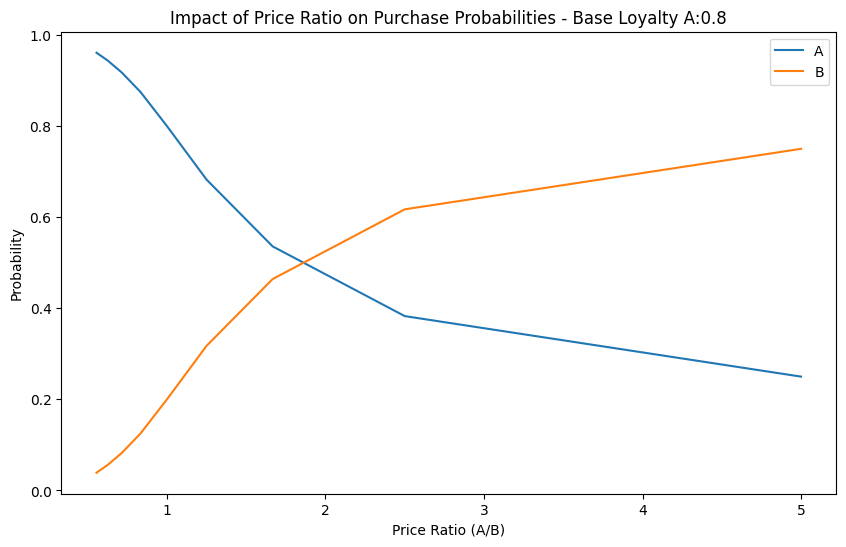

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(Price_Ratio, A_probs, label='A')  
plt.plot(Price_Ratio, B_probs, label='B')  
plt.xlabel('Price Ratio (A/B)')
plt.ylabel('Probability')
plt.title('Impact of Price Ratio on Purchase Probabilities - Base Loyalty A:0.8')
plt.legend()

In [13]:
get_probability_of_change_in_units_purchased_due_to_price

<function cabm.agent_functions.get_probability_of_change_in_units_purchased_due_to_price(reference_price, current_price, sensitivity_increase=5, sensitivity_decrease=10, threshold=0.01)>

In [14]:
current_prices = np.linspace(1.0,10.0,100)

In [15]:
event_probabilities = [get_probability_of_change_in_units_purchased_due_to_price(reference_price=5.0,current_price=i) for i in current_prices]

In [16]:
price_indices = current_prices/5.0

/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_2894/1309734683.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


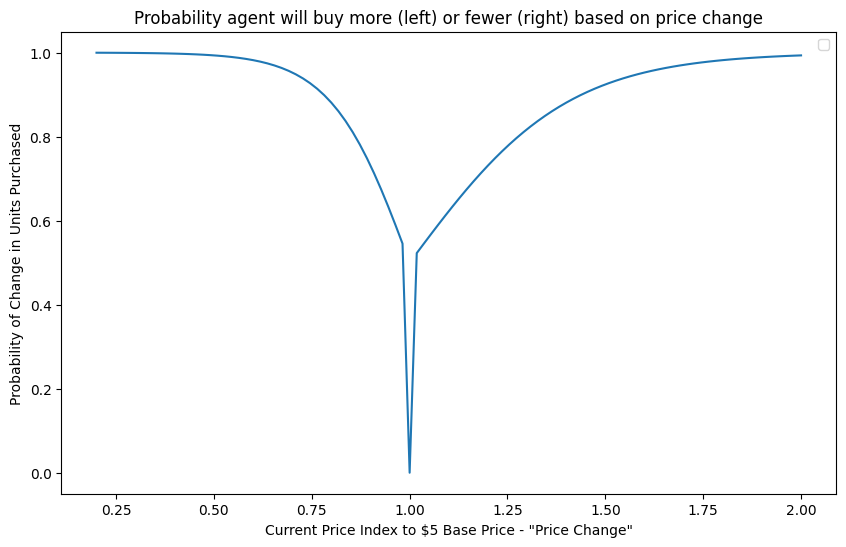

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(price_indices, event_probabilities)  
plt.xlabel('Current Price Index to $5 Base Price - "Price Change"')
plt.ylabel('Probability of Change in Units Purchased')
plt.title('Probability agent will buy more (left) or fewer (right) based on price change')
plt.legend()

In [38]:
adstocks = np.logspace(1,6,100)

In [51]:
probs = [get_probability_of_change_in_units_purchased_due_to_adstock(i,sensitivity=0.01)  for i in adstocks]

/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_2894/2807997939.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


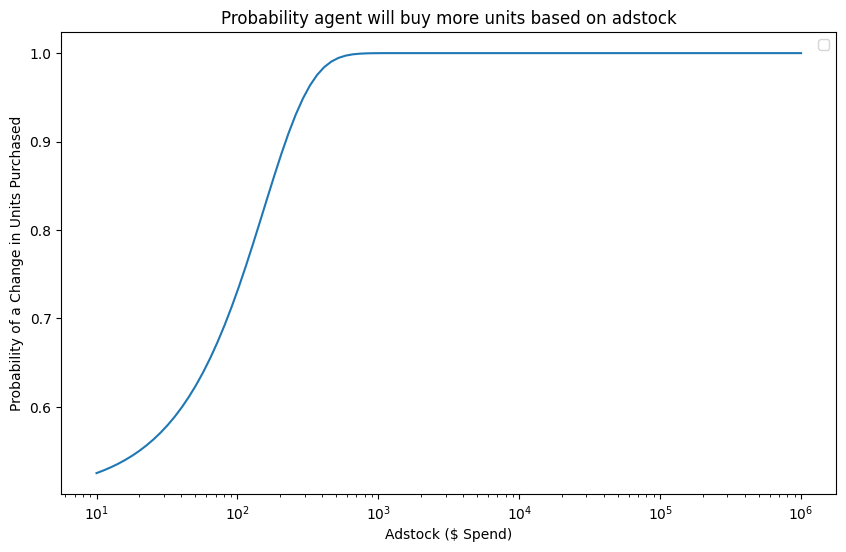

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(adstocks, probs)  
plt.xlabel('Adstock ($ Spend)')
plt.ylabel('Probability of a Change in Units Purchased')
plt.title('Probability agent will buy more units based on adstock')
plt.xscale("log")
plt.legend()

In [70]:
def get_probability_of_additional_purchase_due_to_adstock(
    adstock: float,
    sensitivity: float = 1,
    midpoint: float = 1000,
) -> float:
    """
    This function calculates the probability of an additional purchase based on the adstock value.

    Parameters:
    adstock (float): The adstock value.
    sensitivity (float): The sensitivity factor for adstock. Default is 1.
    midpoint (float): The midpoint of the logistic curve. Default is 1000.

    Returns:
    float: The probability of an additional purchase.
    """
    # Use the logistic function to model the probability
    probability = 1 / (1 + np.exp(-sensitivity * (np.log10(adstock) - np.log10(midpoint))))

    return probability

In [75]:
probs = [get_probability_of_additional_purchase_due_to_adstock(i)  for i in adstocks]

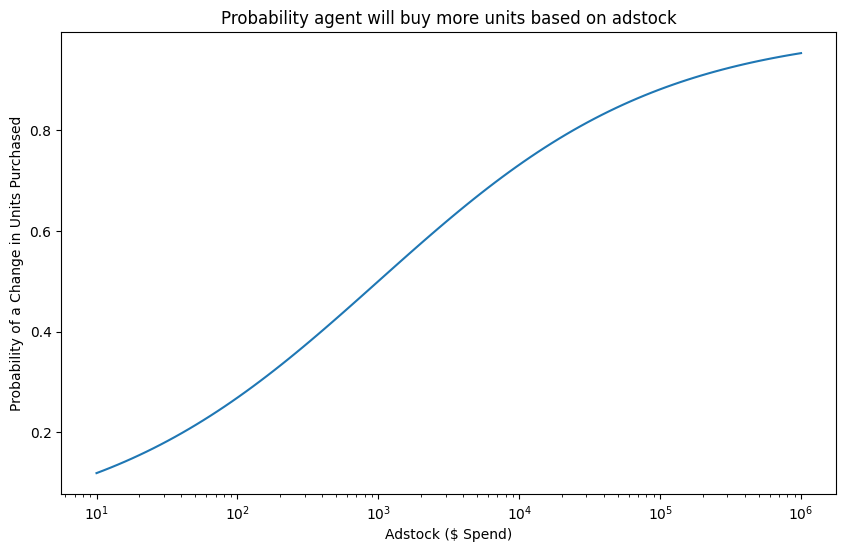

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(adstocks, probs)  
plt.xlabel('Adstock ($ Spend)')
plt.ylabel('Probability of a Change in Units Purchased')
plt.title('Probability agent will buy more units based on adstock')
plt.xscale("log")

In [78]:
def get_probability_of_additional_purchase_due_to_adstock_klotz_adair(
    adstock: float,
    K_d: float = 1000,
    n: float = 1,
) -> float:
    """
    This function calculates the probability of an additional purchase based on the adstock value
    using the Klotz-Adair equation.

    Parameters:
    adstock (float): The adstock value.
    K_d (float): The dissociation constant, controlling the midpoint of the curve. Default is 1000.
    n (float): The Hill coefficient, controlling the steepness of the curve. Default is 1.

    Returns:
    float: The probability of an additional purchase.
    """
    # Use the Klotz-Adair equation to model the probability
    probability = (adstock ** n) / (K_d + adstock ** n)

    return probability

In [83]:
klotz_probs = [get_probability_of_additional_purchase_due_to_adstock_klotz_adair(i,K_d=10000)  for i in adstocks]

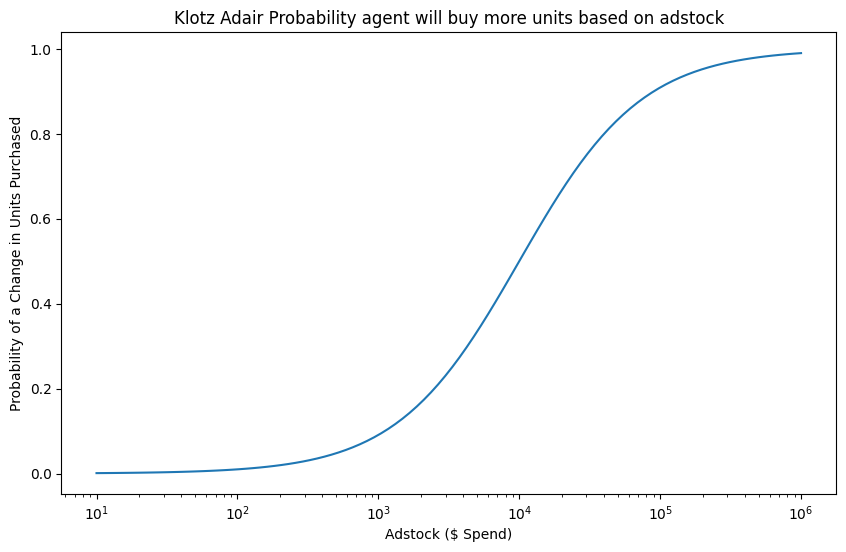

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(adstocks, klotz_probs)  
plt.xlabel('Adstock ($ Spend)')
plt.ylabel('Probability of a Change in Units Purchased')
plt.title('Klotz Adair Probability agent will buy more units based on adstock')
plt.xscale("log")